In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.regularizers import l2
from tensorflow.keras import models


from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

import pickle

import tensorflow as tf
tf.config.run_functions_eagerly(True)

import matplotlib.pyplot as plt

In [2]:
from funcs.nasdaq_data_collector import collect_nasdaq_data

try:
    df = pd.read_csv("faang_nasdaq_extended_data.csv")
except:
    data_config = {
        "tickers": ["META", "AAPL", "AMZN", "NFLX", "GOOGL", "^IXIC"],
        "start_date": "2015-01-01",
        "end_date": "2024-12-31"
    }
    df = collect_nasdaq_data(data_config)
df['^IXIC-Change Rate'] = df['^IXIC-Close'].pct_change()
df.dropna(inplace=True)
df.set_index("Date", inplace=True)

#### Standardization

In [3]:
min(df.index), max(df.index)

('2015-03-17', '2024-12-30')

In [4]:
from funcs.features_scaling import FeaturesScaler
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler, RobustScaler


SCALING_METHODS = {
    'target': {'cols': ['^IXIC-Close'], 
            'scaler': RobustScaler()},
    'price': {'pattern': ['Open', 'High', 'Low', 'Close'],
              'exclude': ['^IXIC-Close'],
              'scaler': MinMaxScaler()},
    'volume': {'pattern': ['Volume'],
               'scaler': FunctionTransformer(np.log1p, validate=True)},
    'indicators': {
        'RSI': {'pattern': ['RSI'], 'scaler': MinMaxScaler()},
        'MACD': {'pattern': ['MACD'], 'scaler': StandardScaler()},
        'ATR': {'pattern': ['ATR'], 'scaler': StandardScaler()},
        'SMA': {'pattern': ['SMA'], 'scaler': MinMaxScaler()},
        'EMA': {'pattern': ['EMA'], 'scaler': MinMaxScaler()}
    }
}


Scaler = FeaturesScaler(SCALING_METHODS)
df  = Scaler.scale_features(df)
df['^IXIC-Close'] = Scaler.scale_target(df)


In [5]:
from funcs.data_splitting import TimeSeriesDataSplitter
config = {
    'seq_length': 60,
    'train_size': 0.8,
    'val_size': 0.15,
    'target_columns': ['^IXIC-Close']
}
splitter = TimeSeriesDataSplitter(config)

# Prepare and split data
target_col = "^IXIC-Close"
dim_features = [col for col in df.columns if col != target_col]
data_scaled = df[dim_features].values
target_scaled = df[[target_col]].values
splits = splitter.prepare_data(data_scaled, target_scaled)

# Access the splits
X_train, y_train = splits['train']
X_val, y_val = splits['val']
X_test, y_test = splits['test']

X_train.shape, X_test.shape, X_val.shape


((1636, 60, 56), (481, 60, 56), (288, 60, 56))

## NOP Model

In [9]:
batch_size = 64
latent_dim = 20

log_dir = f"logs/NOP-D{len(dim_features)}to{latent_dim}-S{config['seq_length']}-B{batch_size}"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Define model
nop_model = Sequential([
    # --- Encoder ---
    LSTM(len(dim_features), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), bias_initializer=RandomNormal(mean=0.1, stddev=0.05)),
    LSTM(latent_dim, return_sequences=False),
    Dropout(0.2),

    # --- Nonlinear Mapping ---
    Dense(20, activation='relu'),
    Dropout(0.2),
    Dense(18, activation='relu' , kernel_regularizer=l2(0.01)),
    
    # --- Decoder ---
    RepeatVector(X_train.shape[1]),
    LSTM(32, return_sequences=True),
    LSTM(15, return_sequences=True),
    # Output layer
    TimeDistributed(Dense(1, activation='linear'))
])


nop_model.name = f"NOP-D{len(dim_features)}to{latent_dim}-S{config['seq_length']}-B{batch_size}"
Optimizer = Adam(learning_rate=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=1e-6)
loss_fn = Huber(delta=3.0)

nop_model.compile(optimizer=Optimizer, loss=loss_fn)

nop_model.summary()

/Users/paullin/Desktop/NOP Implmentation/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "NOP-D56to20-S60-B64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 56)         │        25,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 20)             │         6,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 18)             │           378 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 60, 18)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 60, 32)         │         6,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 60, 15)         │         2,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 60, 1)          │            16 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,694 (162.87 KB)

 Trainable params: 41,694 (162.87 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train model
epochs = 100
history = nop_model.fit(
    X_train, y_train, 
    epochs=epochs, batch_size=batch_size, 
    validation_data=(X_test, y_test), 
    verbose=1, callbacks=[tensorboard_callback, reduce_lr, early_stopping]
)

/Users/paullin/Desktop/NOP Implmentation/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 254ms/step


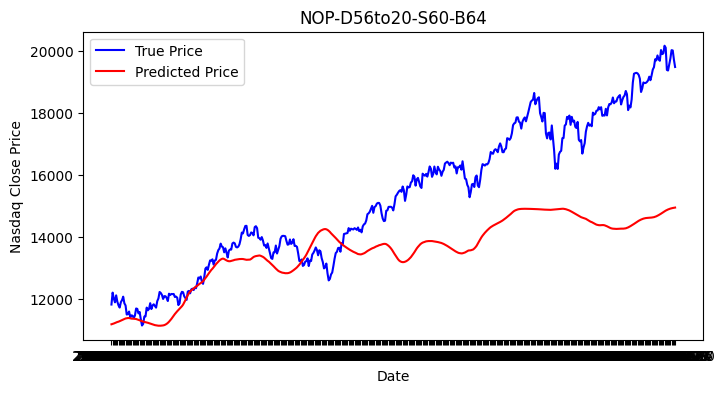

In [12]:
nop_model = models.load_model(f"models/NOP-D56to20-S60-B64.keras")
# Prediction
nop_y_pred = nop_model.predict(X_test)

# Reverse Scaling

nop_y_pred_inv = Scaler.scale_target(df = None, inv_data=nop_y_pred[:, -1, :],  inverse=True)
nop_y_test_inv = Scaler.scale_target(df = None, inv_data=y_test, inverse=True)

# Draw Prediction Result
plt.figure(figsize=(8,4))
plt.title(nop_model.name)
plt.plot(df.index[-len(y_test):], nop_y_test_inv, label="True Price", color='blue')
plt.plot(df.index[-len(y_test):], nop_y_pred_inv, label="Predicted Price", color='red')
plt.xlabel("Date")
plt.ylabel("Nasdaq Close Price")
plt.legend()
plt.show()

/Users/paullin/Desktop/NOP Implmentation/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 248ms/step


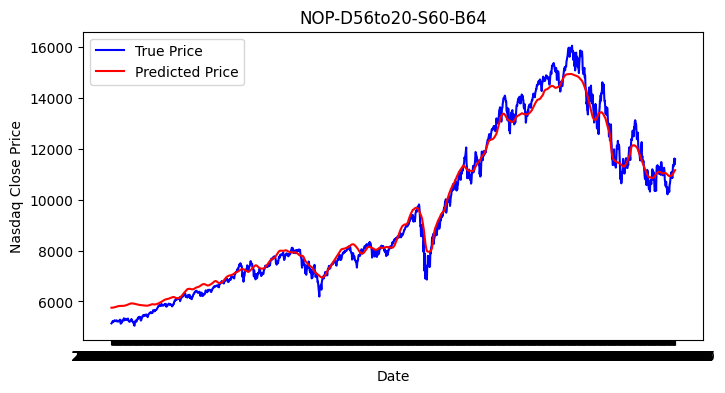

In [20]:
# Prediction
y_pred = nop_model.predict(X_train)

# Reverse Scaling

y_pred_inv = Scaler.scale_target(df = None, inv_data=y_pred[:, -1, :],  inverse=True)
y_train_inv = Scaler.scale_target(df = None, inv_data=y_train, inverse=True)

# Draw Prediction Result
plt.figure(figsize=(8,4))
plt.title(nop_model.name)
plt.plot(df.index[-len(y_train_inv):], y_train_inv, label="True Price", color='blue')
plt.plot(df.index[-len(y_train_inv):], y_pred_inv, label="Predicted Price", color='red')
plt.xlabel("Date")
plt.ylabel("Nasdaq Close Price")
plt.legend()
plt.show()

In [21]:
nop_model.save(f"models/{nop_model.name}.keras")

## LSTM Model

In [8]:
log_dir = f"logs/LSTM-D{len(dim_features)}-S{config['seq_length']}-B{batch_size}"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


lstm_model = Sequential([
    LSTM(48, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=True),
    LSTM(16, return_sequences=True),
    Dropout(0.2),
    Dense(1) 
])


Optimizer = Adam(learning_rate=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=1e-6)
loss_fn = Huber(delta=3.0)

lstm_model.compile(optimizer=Optimizer, loss=loss_fn)

/Users/paullin/Desktop/NOP Implmentation/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
# Train model
epochs = 100
history = lstm_model.fit(
    X_train, y_train, 
    epochs=epochs, batch_size=batch_size, 
    validation_data=(X_test, y_test), 
    verbose=1, callbacks=[tensorboard_callback, reduce_lr, early_stopping]
)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 421ms/step - loss: 0.0574 - val_loss: 0.1253 - learning_rate: 0.0010
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 416ms/step - loss: 0.0222 - val_loss: 0.0907 - learning_rate: 0.0010
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 416ms/step - loss: 0.0156 - val_loss: 0.0886 - learning_rate: 0.0010
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 418ms/step - loss: 0.0116 - val_loss: 0.0748 - learning_rate: 0.0010
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 419ms/step - loss: 0.0095 - val_loss: 0.0574 - learning_rate: 0.0010
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 416ms/step - loss: 0.0090 - val_loss: 0.0487 - learning_rate: 0.0010
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 417ms/step - loss: 0.0081 - val_loss: 0.0468 - learning_rate: 0.0010
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 419ms/step - loss: 0.0071 - val_loss: 0.0417 - learning_rate: 0.0010
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 434ms/step - loss: 0.0065 - val_loss: 0.0403 - learning_rate:

In [13]:
lstm_model.save(f"models/LSTM-D{len(dim_features)}-S{config['seq_length']}-B{batch_size}.keras")

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step


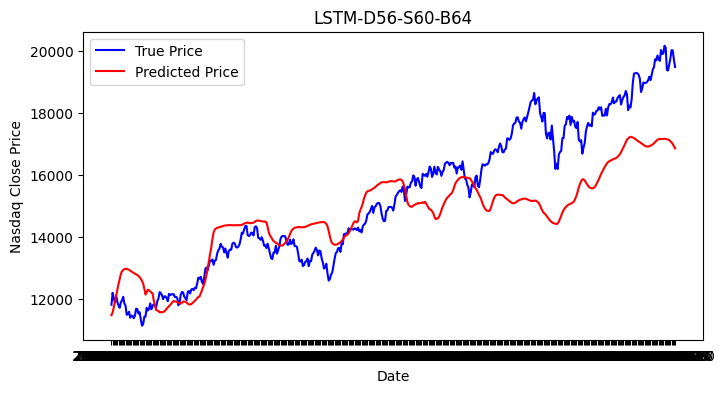

In [10]:
# Prediction
lstm_y_pred = lstm_model.predict(X_test)

# Reverse Scaling

lstm_y_pred_inv = Scaler.scale_target(df = None, inv_data=lstm_y_pred[:,-1,:],  inverse=True)
lstm_y_test_inv = Scaler.scale_target(df = None, inv_data=y_test, inverse=True)

# Draw Prediction Result
plt.figure(figsize=(8,4))
plt.title(f"LSTM-D{len(dim_features)}-S{config['seq_length']}-B{batch_size}")
plt.plot(df.index[-len(y_test):], lstm_y_test_inv, label="True Price", color='blue')
plt.plot(df.index[-len(y_test):], lstm_y_pred_inv, label="Predicted Price", color='red')
plt.xlabel("Date")
plt.ylabel("Nasdaq Close Price")
plt.legend()
plt.show()

/Users/paullin/Desktop/NOP Implmentation/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step


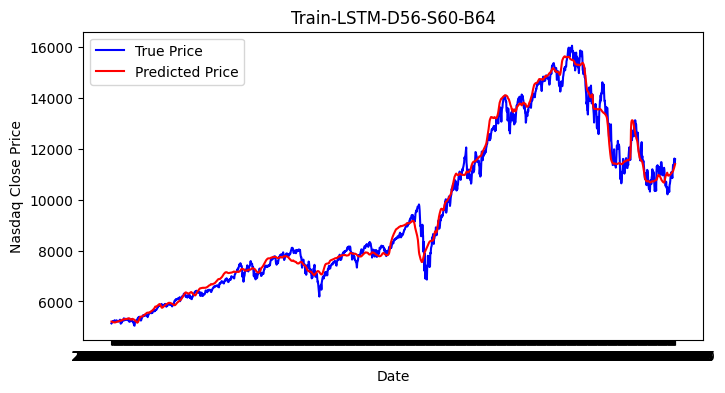

In [12]:
# Prediction
lstm_y_pred = lstm_model.predict(X_train)

# Reverse Scaling

lstm_y_pred_inv = Scaler.scale_target(df = None, inv_data=lstm_y_pred[:,-1,:],  inverse=True)
lstm_y_train_inv = Scaler.scale_target(df = None, inv_data=y_train, inverse=True)

# Draw Prediction Result
plt.figure(figsize=(8,4))
plt.title(f"Train-LSTM-D{len(dim_features)}-S{config['seq_length']}-B{batch_size}")
plt.plot(df.index[-len(lstm_y_train_inv):], lstm_y_train_inv, label="True Price", color='blue')
plt.plot(df.index[-len(lstm_y_train_inv):], lstm_y_pred_inv, label="Predicted Price", color='red')
plt.xlabel("Date")
plt.ylabel("Nasdaq Close Price")
plt.legend()
plt.show()

## FPSLR Model

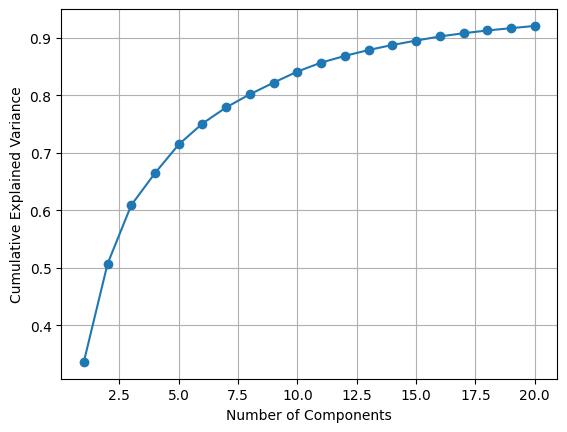

Optimal number of components: 8


In [6]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

pca = PCA(20)
pca.fit(X_train_flat)
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

plt.plot(np.arange(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid()
plt.show()
n_components = np.argmax(explained_variance_ratio >= 0.8) + 1
print(f"Optimal number of components: {n_components}")


In [7]:
pca = PCA(n_components=n_components) 
X_train_reduced = pca.fit_transform(X_train_flat)
X_test_reduced = pca.transform(X_test_flat)

degree = 2
fplsr_model = make_pipeline(PolynomialFeatures(degree, interaction_only=True), Lasso(alpha=0.01))

fplsr_model.fit(X_train_reduced, y_train)

Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(interaction_only=True)),
                ('lasso', Lasso(alpha=0.01))])

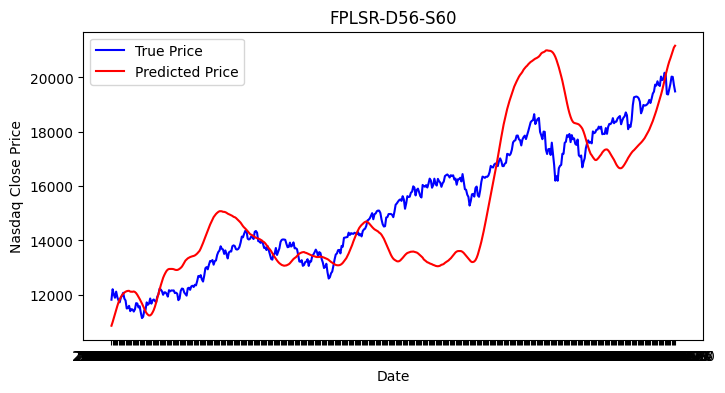

In [26]:
# Prediction
fplsr_y_pred = fplsr_model.predict(X_test_reduced)

# Reverse Scaling

fplsr_y_pred_inv = Scaler.scale_target(df = None, inv_data=fplsr_y_pred.reshape(-1,1),  inverse=True)
fplsr_y_test_inv = Scaler.scale_target(df = None, inv_data=y_test, inverse=True)

# Draw Prediction Result
plt.figure(figsize=(8,4))
plt.title(f"FPLSR-D{len(dim_features)}-S{config['seq_length']}")
plt.plot(df.index[-len(y_test):], fplsr_y_test_inv, label="True Price", color='blue')
plt.plot(df.index[-len(y_test):], fplsr_y_pred_inv, label="Predicted Price", color='red')
plt.xlabel("Date")
plt.ylabel("Nasdaq Close Price")
plt.legend()
plt.show()

In [49]:


with open(f"models/FPLSR-PCA-D{len(dim_features)}to{n_components}-S{config['seq_length']}-Lasso-alpha{0.01}.pkl", "wb") as f:
    pickle.dump(fplsr_model, f)


# Model Comparison

In [8]:

lstm_model = models.load_model(f"models/LSTM-D56-S60-B64.keras")
nop_model = models.load_model(f"models/NOP-D56to20-S60-B64.keras")
with open("models/FPLSR-PCA-D56to8-S60-Lasso-alpha0.01.pkl", "rb") as f:
    fplsr_model = pickle.load(f)

/Users/paullin/Desktop/NOP-vs-FPLSR-OnNasdaq_index/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 252ms/step


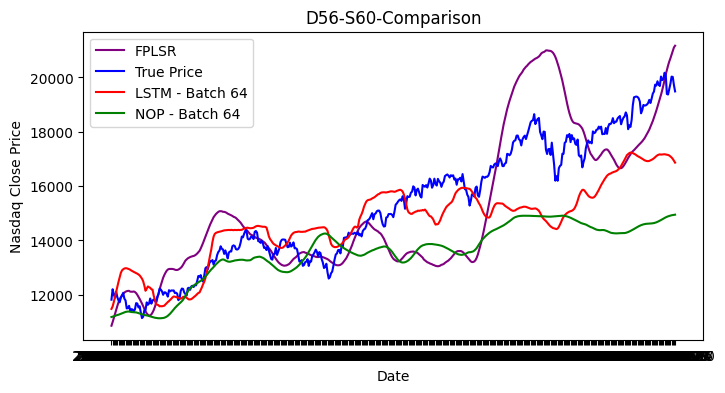

In [10]:

# Prediction
lstm_y_pred = lstm_model.predict(X_test)
nop_y_pred = nop_model.predict(X_test)
fplsr_y_pred = fplsr_model.predict(X_test_reduced)

# Reverse Scaling
nop_y_pred_inv = Scaler.scale_target(df = None, inv_data=nop_y_pred[:,-1,:],  inverse=True)
fplsr_y_pred_inv = Scaler.scale_target(df = None, inv_data=fplsr_y_pred.reshape(-1,1),  inverse=True)
lstm_y_pred_inv = Scaler.scale_target(df = None, inv_data=lstm_y_pred[:,-1,:],  inverse=True)
lstm_y_test_inv = Scaler.scale_target(df = None, inv_data=y_test, inverse=True)

# Draw Prediction Result
plt.figure(figsize=(8,4))
plt.title(f"D{len(dim_features)}-S{config['seq_length']}-Comparison")
plt.plot(df.index[-len(y_test):], fplsr_y_pred_inv, label="FPLSR", color='purple')
plt.plot(df.index[-len(y_test):], lstm_y_test_inv, label="True Price", color='blue')
plt.plot(df.index[-len(y_test):], lstm_y_pred_inv, label="LSTM - Batch 64", color='red')
plt.plot(df.index[-len(y_test):], nop_y_pred_inv, label="NOP - Batch 64", color='green')
plt.xlabel("Date")
plt.ylabel("Nasdaq Close Price")
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape
    }

# Calculate metrics for each model
lstm_metrics = calculate_metrics(lstm_y_test_inv, lstm_y_pred_inv)
nop_metrics = calculate_metrics(lstm_y_test_inv, nop_y_pred_inv)
fplsr_metrics = calculate_metrics(lstm_y_test_inv, fplsr_y_pred_inv)

# Create comparison table
metrics_df = pd.DataFrame({
    'LSTM': lstm_metrics,
    'NOP': nop_metrics,
    'FPLSR': fplsr_metrics
})

print("\nModel Performance Metrics:")
metrics_df.round(4)


Model Performance Metrics:


,LSTM,NOP,FPLSR
MAE,1.165704e+03,1.822416e+03,1.246065e+03
MSE,2.120219e+06,5.354029e+06,2.503121e+06
RMSE,1.456097e+03,2.313878e+03,1.582125e+03
R2,6.236000e-01,4.950000e-02,5.556000e-01
MAPE,7.189400e+00,1.086960e+01,7.883300e+00


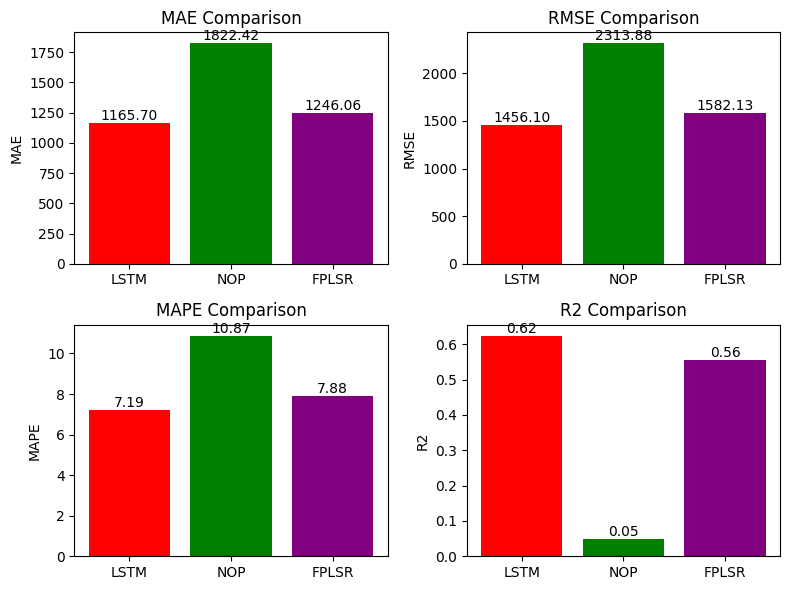

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create subplots for bar charts
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

# Flatten axes for easier iteration
axes = axes.flatten()

# Plot individual metrics as bar charts
metrics_to_plot = ['MAE', 'RMSE', 'MAPE', 'R2']
colors = ['Red', 'Green', 'Purple']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    values = metrics_df.loc[metric]
    
    bars = ax.bar(metrics_df.columns, values, color=colors)
    ax.set_title(f'{metric} Comparison')
    ax.set_ylabel(metric)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()